In [39]:
import os, sys
from pathlib import Path
import urllib.request
from collections import Counter, defaultdict
import string
import re
from importlib import reload

import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import tensorflow as tf
%matplotlib inline

import models.fasttext as fasttext
reload(fasttext);

In [2]:
tv_show = "friends"

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

root_path = Path().resolve().joinpath("..")
show_data_path = root_path.joinpath("scrape", "data", tv_show, "parsed")
embeddings_path = root_path.joinpath("embeddings", "newscrawl.300d.W.pos.vectors.gz")
embeddings_url = "https://www.dropbox.com/s/kguufyc2xcdi8yk/lexvec.enwiki%2Bnewscrawl.300d.W.pos.vectors.gz?dl=1"

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /Users/andy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/andy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
if not os.path.isfile(embeddings_path):
    print("downloading embeddings...")
    urllib.request.urlretrieve(embeddings_url, embeddings_path)

!gunzip {str(embeddings_path)}

/Users/andy/Documents/projects/w266-final/analysis/../embeddings/newscrawl.300d.W.pos.vectors already exists -- do you wish to overwrite (y or n)? ^C


## Load the Training Data

In [4]:
dialog_datas = []

for filename in os.listdir(show_data_path):
    dialog_data = pd.read_csv(show_data_path.joinpath(filename), header=None, names=("speaker", "utterance"))
    dialog_data["episode"] = filename.split(".")[0]
    dialog_datas.append(dialog_data)
    
all_dialog_data = pd.concat(dialog_datas).dropna().reset_index(drop=True)

In [5]:
print(all_dialog_data.count())
all_dialog_data.head()

speaker      55025
utterance    55025
episode      55025
dtype: int64


,speaker,utterance,episode
0,Phoebe,"Oh, hey Joey.",1012
1,Joey,"Uh, hey.",1012
2,Phoebe,"Listen, I need to ask you something. Ok, you k...",1012
3,Joey,Yeah.,1012
4,Phoebe,"Yeah. Well, uhm... listen he was supposed to g...",1012


## Data Pre-processing and Minor Analysis

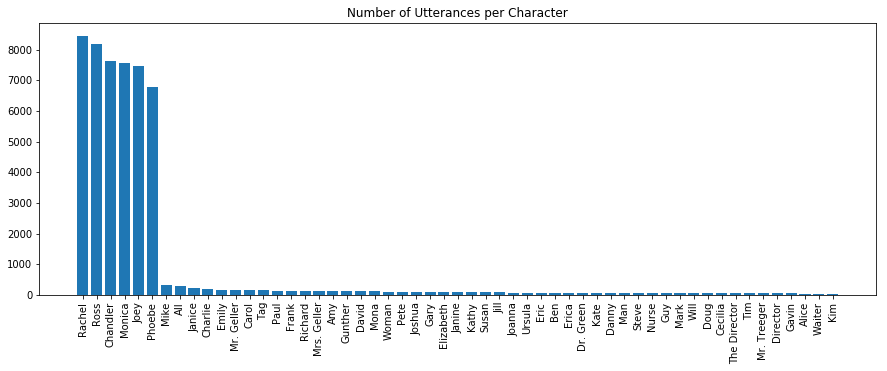

In [15]:
speaker_value_counts = all_dialog_data.speaker.value_counts()
major_speaker_value_counts = speaker_value_counts[speaker_value_counts > 40]
x, y = major_speaker_value_counts.index, major_speaker_value_counts.values

fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(111)
sub.bar(x, y)
for tick in sub.get_xticklabels():
    tick.set_rotation(90)
plt.title("Number of Utterances per Character")
plt.show()

In [16]:
num_major_characters = 6
major_characters = x[:num_major_characters]
major_characters_set = set(major_characters)

In [17]:
labels_to_ids = {}
ids_to_labels = {}
for i, major_character in enumerate(major_characters):
    labels_to_ids[major_character] = i
    ids_to_labels[i] = major_character
labels_to_ids

{'Rachel': 0, 'Ross': 1, 'Chandler': 2, 'Monica': 3, 'Joey': 4, 'Phoebe': 5}

In [18]:
major_dialog_data = all_dialog_data[all_dialog_data.speaker.isin(major_characters_set)]
print(major_dialog_data.count())

speaker      46079
utterance    46079
episode      46079
dtype: int64


In [19]:
tokenizer = nltk.tokenize.TreebankWordTokenizer()

labels = major_dialog_data.speaker

#utterances = list(map(lambda utter: tokenizer.tokenize(utter.lower()), major_dialog_data.utterance))
utterances = [tokenizer.tokenize(utter.lower()) for utter in major_dialog_data.utterance]
embeddings = KeyedVectors.load_word2vec_format(root_path.joinpath("embeddings", "newscrawl.300d.W.pos.vectors"), binary=False)

Text(0.5, 1.0, 'Histogram of Utterance lengths')

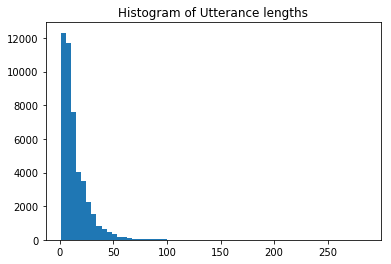

In [20]:
plt.hist([len(words) for words in utterances], bins=60)
plt.title("Histogram of Utterance lengths")

## Baseline Model - Always predict the most common class

In [21]:
np.mean(labels == major_characters[0])

0.1832939082879403

In [22]:
def shuffle(x, y):
    m = x.shape[0]
    rand_perm = np.random.permutation(m)
    x = x[rand_perm]
    y = y[rand_perm]
    return x, y

def batch_iter(x, y, batch_size):
    num_batches = int(np.ceil(x.shape[0] / batch_size))
    for i in range(num_batches):
        start = i * batch_size
        end = start + batch_size
        yield i, x[start:end], y[start:end]

## Baseline Model - Logistic Regression over CBOW

Pretty much the simplest model we could use. This will serve as a good baseline. It just uses pre-trained Word2Vec and its vocabulary.

In [23]:
non_empty_utterances = []
non_empty_utterance_labels = []

for i, utterance in enumerate(utterances):
    words = [word for word in utterance if word in embeddings.vocab and word not in stop_words]
    if len(words) > 0:
        non_empty_utterances.append(words)
        non_empty_utterance_labels.append(labels.iloc[i])

bags = np.zeros((len(non_empty_utterances), embeddings.vector_size))

for i, utterance in enumerate(non_empty_utterances):
    #bag = np.sum(embeddings.word_vec(word) for word in utterance if word in embeddings.vocab)
    words = [word for word in utterance if word in embeddings.vocab]
    vectors = np.zeros((len(words), embeddings.vector_size))
    for j, word in enumerate(words):
        vectors[j, :] = embeddings.word_vec(word)
    bag = np.mean(vectors, axis=0)
    bags[i, :] = bag

train_cut = math.ceil(major_dialog_data.utterance.count() * 0.85)
train_x = bags[0:train_cut]
train_y = non_empty_utterance_labels[0:train_cut]
test_x = bags[train_cut:]
test_y = non_empty_utterance_labels[train_cut:]

print(train_x.shape, test_x.shape)

(39168, 300) (4216, 300)


In [24]:
model = LogisticRegression(multi_class="ovr")
model.fit(train_x, train_y)
print(model.score(train_x, train_y))
print(model.score(test_x, test_y))

/Users/andy/miniconda3/envs/noble/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.2796415441176471
0.2333965844402277


## Model - Facebook Fasttext
[https://arxiv.org/abs/1607.01759](https://arxiv.org/abs/1607.01759)

In [25]:
counter = Counter()
stemmer = PorterStemmer()

custom_tokenized = []
for utterance in major_dialog_data.utterance:
    words = re.findall(r"[a-z0-9']+", utterance.lower())
    # remove dangling apostrophes and 's at the end of words
    words = [re.sub(r"'s?$", "", stemmer.stem(word)) for word in words]
    custom_tokenized.append(words)
    
for utterance in custom_tokenized:
    counter.update(word for word in utterance if word not in string.punctuation)
    
vocab = [k for k, v in counter.most_common() if v > 2]

vocab_word_to_id = defaultdict(lambda: -1)
vocab_id_to_word = {}
for i, word in enumerate(vocab):
    vocab_id_to_word[i] = word
    vocab_word_to_id[word] = i

In [29]:
label_ids = np.array([labels_to_ids[label] for label in labels])
train_x_fasttext = custom_tokenized[:train_cut]
train_y_fasttext = label_ids[:train_cut]
test_x_fasttext = custom_tokenized[train_cut:]
test_y_fasttext = label_ids[train_cut:]

train_x_fasttext = np.array([" ".join(words) for words in train_x_fasttext])
test_x_fasttext = np.array([" ".join(words) for words in test_x_fasttext])

In [42]:
tf.reset_default_graph()
fasttext_model = fasttext.FastText(vocab, num_major_characters, regularize_coef=0.1)

In [43]:
display_step = 20
num_epochs = 40
batch_size = 128

train_writer = tf.summary.FileWriter("./fasttext-board/train")
test_writer = tf.summary.FileWriter("./fasttext-board/test")
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    train_writer.add_graph(sess.graph)
    
    global_step = 0
    X = fasttext_model.X
    Y = fasttext_model.Y

    for epoch in range(num_epochs):
        print("{} epoch number: {}".format(datetime.now(), epoch + 1))
        train_x_fasttext, train_y_fasttext = shuffle(train_x_fasttext, train_y_fasttext)
        
        for step, x_batch, y_batch in batch_iter(train_x_fasttext, train_y_fasttext, batch_size):
            global_step += 1
            sess.run(fasttext_model.train_op, feed_dict={ X: x_batch, Y: y_batch })

            # every so often, report the progress of our loss and training accuracy
            if step % display_step == 0:
                summ = sess.run(fasttext_model.merged_summary, feed_dict={ X: x_batch, Y: y_batch })
                train_writer.add_summary(summ, global_step=global_step)
                train_writer.flush()

        test_acc = sess.run(fasttext_model.accuracy, feed_dict={ X: test_x_fasttext, Y: test_y_fasttext })
        summ = sess.run(fasttext_model.merged_summary, feed_dict={ X: test_x_fasttext, Y: test_y_fasttext })
        test_writer.add_summary(summ, global_step=global_step)
        test_writer.flush()
        print("test accuracy = {:.4f}".format(test_acc))
    
    # save the model to disk so we can load it up later for use by `./eval.py`
    saver.save(sess, "./fasttext-ckpt/model.ckpt")

2018-11-07 09:54:54.936106 epoch number: 1
test accuracy = 0.1962
2018-11-07 09:54:56.435248 epoch number: 2
test accuracy = 0.1839
2018-11-07 09:54:57.651634 epoch number: 3
test accuracy = 0.1820
2018-11-07 09:54:58.958759 epoch number: 4
test accuracy = 0.1817
2018-11-07 09:55:00.196494 epoch number: 5
test accuracy = 0.1819
2018-11-07 09:55:01.424704 epoch number: 6
test accuracy = 0.1820
2018-11-07 09:55:02.609493 epoch number: 7
test accuracy = 0.1823
2018-11-07 09:55:03.940126 epoch number: 8
test accuracy = 0.1952
2018-11-07 09:55:05.405701 epoch number: 9
test accuracy = 0.1919
2018-11-07 09:55:06.710256 epoch number: 10
test accuracy = 0.2072
2018-11-07 09:55:08.005280 epoch number: 11
test accuracy = 0.2021
2018-11-07 09:55:09.302799 epoch number: 12
test accuracy = 0.2191
2018-11-07 09:55:10.538514 epoch number: 13
test accuracy = 0.2196
2018-11-07 09:55:11.756162 epoch number: 14
test accuracy = 0.2243
2018-11-07 09:55:13.014628 epoch number: 15
test accuracy = 0.2251
2018